
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

## Pitch Your Project

In the three cells immediately following, describe WHAT you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), WHY you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and HOW you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

### WHAT

### WHY

### HOW

## Pitch Your Sample

In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

### Which (words)?

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [13]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [16]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [17]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'check_scoring', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_arg

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [19]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF.head()

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0


We can also look at the distinguishing features in each cluster:

In [20]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 mac
 thanks
 just
 does
 drive
 apple
 like
 don
 new


Cluster 1:
 car
 cars
 engine
 like
 just
 good
 think
 don
 oil
 dealer


Cluster 2:
 window
 server
 use
 motif
 using
 program
 widget
 application
 like
 code


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [21]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [22]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [23]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

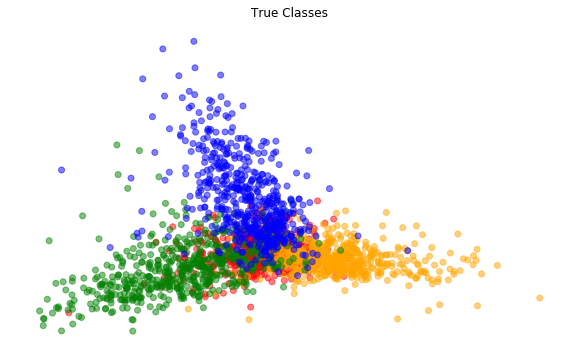

In [24]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

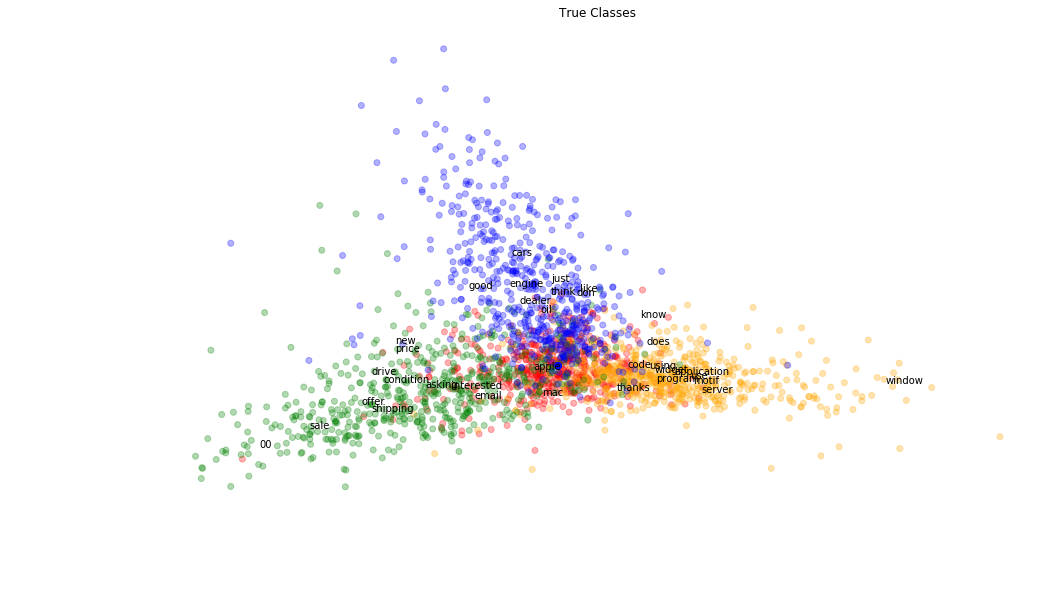

In [25]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [26]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

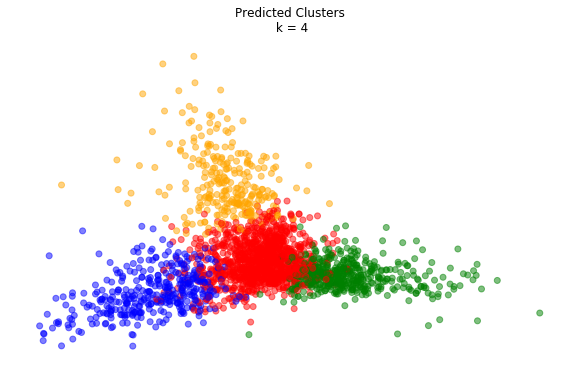

In [27]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [28]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

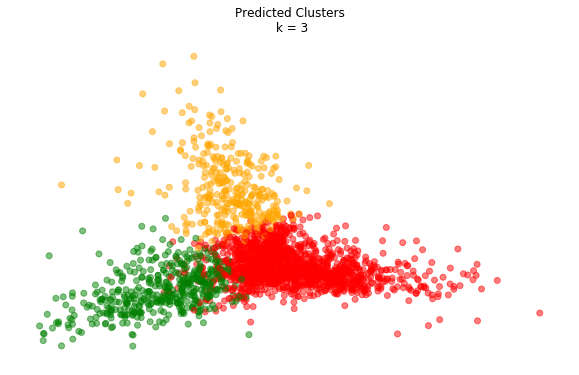

In [30]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km3.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [31]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

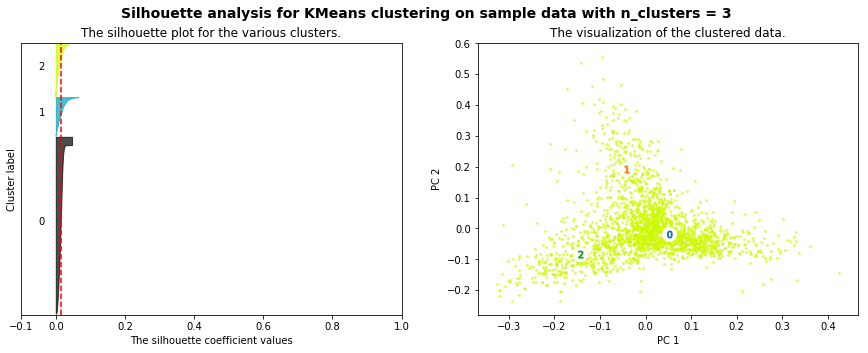

For n_clusters = 3, The average silhouette_score is : 0.014


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

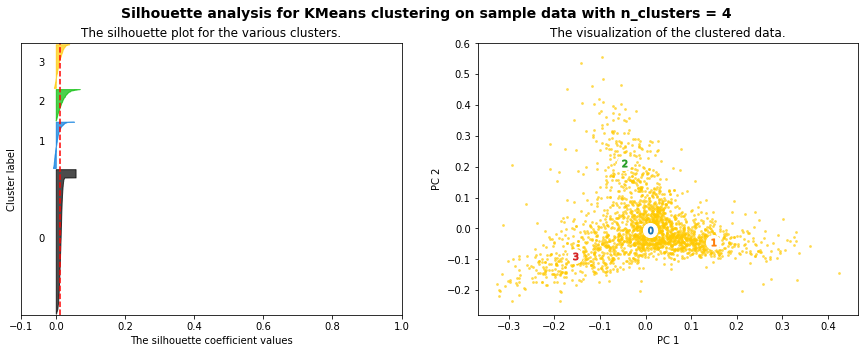

For n_clusters = 4, The average silhouette_score is : 0.012


In [33]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

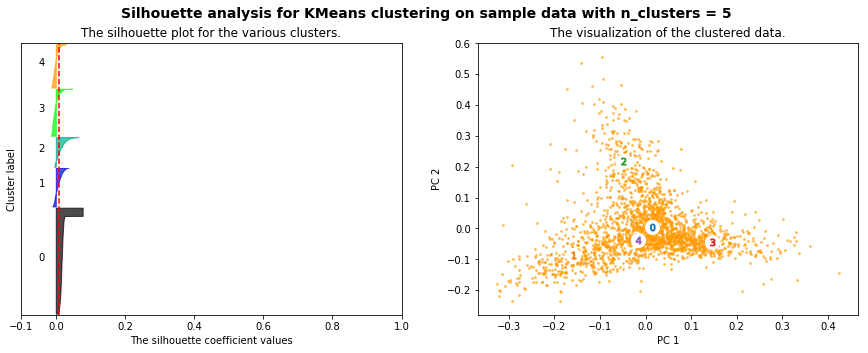

For n_clusters = 5, The average silhouette_score is : 0.010


In [34]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

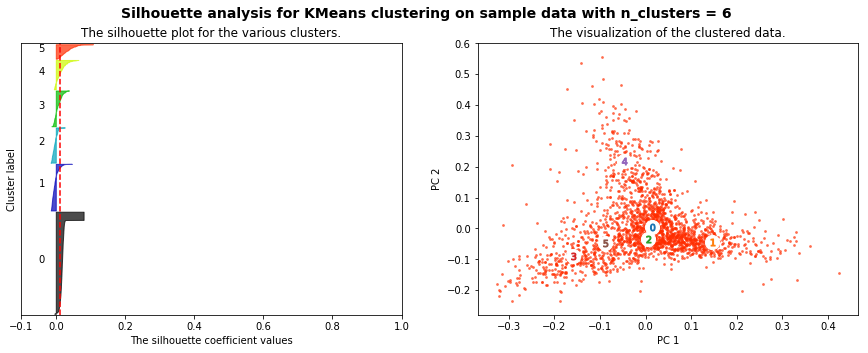

For n_clusters = 6, The average silhouette_score is : 0.011


In [35]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [4]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [5]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [6]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [39]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [40]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [41]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize:

In [42]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

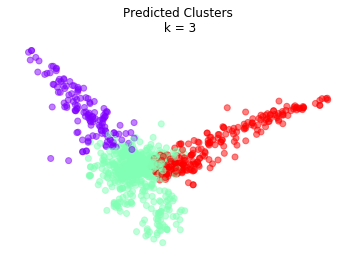

In [43]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [44]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF.head()

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

First, I will load and clean my corpus which consists of episode transcripts of This American Life.

In [28]:
import json
import re

In [29]:
# load text
with open('../../tal-scrape/mapping_info.json') as f:
    mapping = json.load(f)
to_concat = []
for key, val in mapping.items():
    by_yr = mapping[key]
    name_df = pd.DataFrame.from_dict(by_yr, orient='index',
                                     columns=['url']).reset_index(). \
                            rename(columns={'index': 'name'})
    name_df['year'] = key
    to_concat.append(name_df)
total_names = pd.concat(to_concat)

with open('../../tal-scrape/transcripts.json') as f:
    transcripts = json.load(f)
text_df = pd.DataFrame.from_dict(transcripts, orient='index',
                                 columns=['text']).reset_index(). \
                      rename(columns={'index': 'url'})

tal_df = pd.merge(total_names, text_df, on=['url'])
# clean text
tal_df['text'] = tal_df['text'].str.replace('\n\n', ' ').str.replace('[.!?\\-]', ' ').apply(lambda x: re.sub(r"([a-z])([A-Z])", r"\1 \2", x))

Now, I will prepare my text for clustering. 

In [34]:
# trian count vectorizer
talCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
talVects = talCountVectorizer.fit_transform(tal_df['text'])
print(talVects.shape)

(663, 59675)


In [35]:
# look for word "ira", which occurs often since Ira Glass is the host of TAL
talCountVectorizer.vocabulary_.get('ira')

28121

In [36]:
# tf-idf
talTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(talVects)
#train
talTF = talTFTransformer.transform(talVects)
print(talTF.shape)

(663, 59675)


Looking at the words with the highest TF-IDF scores, we see a variety of words that seem to distinguish this corpus. Words like stead (perhaps should be instead), subset, paint, flinched, and olympic are high on the list.

In [37]:
# examine the words with the highest TF IDF score
x = pd.DataFrame(list(zip(talCountVectorizer.vocabulary_.keys(), talTF.data)))
x.columns=['word','TFIDF score']
x=x.sort_values('TFIDF score', ascending=False)
x.iloc[:20]

,word,TFIDF score
34523,stead,0.668865
20311,subset,0.655503
7454,paint,0.620456
26675,flinched,0.586600
21199,olympic,0.567373
59327,monochrome,0.539966
31357,salamanders,0.535098
52449,spacers,0.504568
43673,escalades,0.497544
18127,prioritized,0.495321


I will use stop words and TF IDF to filter the data.

In [38]:
#initialize
talTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
talTFVects = talTFVectorizer.fit_transform(tal_df['text'])

Now that I've filtered, I look for ira again in the vocabulary set. Since it's so common, it has been filtered out.

In [95]:
# look for ira
try:
    print(talTFVectorizer.vocabulary_['ira'])
except KeyError:
    print('ira is missing')
    print('The available words are: {} ...'.format(list(talTFVectorizer.vocabulary_.keys())[:10]))

ira is missing
The available words are: ['student', 'teachers', 'students', 'social', 'quote', 'girls', 'invited', 'address', 'training', 'teacher'] ...


Next, I will implement KMeans clustering with k=3,4,5,6. Unfortunately I do not have a "ground truth" of clusters so I cannot compute metrics such as homogeneity, completeness, and the adjusted rand score.

In [123]:
# helper functions to run kmeans, interrogate documents and cluster features
def train_km(numClusters, talTFVects):
    km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
    km.fit(talTFVects)
    return km

def cluster_docs(numClusters, km, tal_df):
    tal_df['kmeans_predictions'] = km.labels_
    for i in range(0, numClusters):
        print('Cluster: {}'.format(i))
        print(tal_df[tal_df.kmeans_predictions == i].head()['name'])


def distinguish_features(talTFVectorizer, km, numClusters):
    # distinguishing features
    terms = talTFVectorizer.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(numClusters):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')

Results for k=3. Unfortunately the episode names are not very helpful in distinguishing clusters. This is because podcast episodes will often have catchy, obscure episode titles to draw the listener in. While this works well for TAL, it is not helpful in a clustering exercise. The distinguishing words of each cluster are more helpful. However, there is also an issue with names often appearing as distinguishing words. This is likely because producers are often mentioned in acknolwedgements or as story tellers on the show so are common across some transcripts but also shift over time. For the project, we will likely remove speaker names.

In [108]:
numClusters = 3 
km3 = train_km(numClusters, talTFVects)

In [109]:
cluster_docs(numClusters, km3, tal_df)

Cluster: 0
1                                  Five Women
13                                    LaDonna
37                                 To Be Real
80         It’ll Make Sense When You’re Older
90    The Problem We All Live With - Part Two
Name: name, dtype: object
Cluster: 1
4                  Before the Next One
8                   Crime Scene (2018)
14              In Dog We Trust (2018)
18    If You Build It, Will They Come?
19                   Damned If You Do…
Name: name, dtype: object
Cluster: 2
0    Before Things Went to Hell
2                     The Walls
3              Chip in My Brain
5     My Effing First Amendment
6                   ICE Capades
Name: name, dtype: object


In [110]:
distinguish_features(talTFVectorizer, km3, numClusters)

Top terms per cluster:
Cluster 0:
 chana
 joffe
 walt
 kestenbaum
 davidson
 michael
 goldstein
 bank
 adam
 insurance


Cluster 1:
 koenig
 scott
 paul
 dan
 susan
 jack
 jonathan
 josh
 church
 police


Cluster 2:
 zoe
 cole
 sean
 chace
 iraq
 kestenbaum
 chris
 adam
 republican
 davidson




Results for k=4. Similar issue with episode names and distinguishing words. Cluster 1 seems to have a pretty strong theme having to do with Iraq and the military but the others are obscure.

In [111]:
numClusters = 4
km4 = train_km(numClusters, talTFVects)

cluster_docs(numClusters, km4, tal_df)


Cluster: 0
1                                  Five Women
13                                    LaDonna
37                                 To Be Real
80         It’ll Make Sense When You’re Older
90    The Problem We All Live With - Part Two
Name: name, dtype: object
Cluster: 1
52     Didn’t We Solve This One?
122         Tarred and Feathered
126                    Good Guys
128              Human Spectacle
164                         500!
Name: name, dtype: object
Cluster: 2
0    Before Things Went to Hell
2                     The Walls
3              Chip in My Brain
4           Before the Next One
5     My Effing First Amendment
Name: name, dtype: object
Cluster: 3
7             Change You Can Maybe Believe In
8                          Crime Scene (2018)
14                     In Dog We Trust (2018)
17    It's My Party and I'll Try If I Want To
18           If You Build It, Will They Come?
Name: name, dtype: object


In [112]:
distinguish_features(talTFVectorizer, km4, numClusters)

Top terms per cluster:
Cluster 0:
 chana
 joffe
 walt
 kestenbaum
 davidson
 michael
 goldstein
 bank
 adam
 insurance


Cluster 1:
 adam
 davidson
 iraq
 translator
 iraqi
 military
 israel
 soldiers
 americans
 arabic


Cluster 2:
 sean
 zoe
 cole
 chace
 kestenbaum
 trump
 miki
 meek
 stephanie
 foo


Cluster 3:
 koenig
 jack
 chris
 scott
 paul
 police
 hitt
 dan
 susan
 church




Results for k=5. Cluster 0 has some political elements like president and government. Cluster 1 has financial elements like bank and insurance. Cluster 2 and 3 are a bit more obscure. Finally, Cluster 4 touches on immigration with words like immigration, Trump, democrat.

In [113]:
numClusters = 5
km5 = train_km(numClusters, talTFVects)

cluster_docs(numClusters, km5, tal_df)

Cluster: 0
88     Deep End of the Pool
120            Amateur Hour
154     Thought That Counts
159                 Fiasco!
195               Blackjack
Name: name, dtype: object
Cluster: 1
1                                  Five Women
13                                    LaDonna
37                                 To Be Real
80         It’ll Make Sense When You’re Older
90    The Problem We All Live With - Part Two
Name: name, dtype: object
Cluster: 2
122          Tarred and Feathered
126                     Good Guys
164                          500!
201    Lights, Camera, Christmas!
244              Contents Unknown
Name: name, dtype: object
Cluster: 3
2                          The Walls
3                   Chip in My Brain
4                Before the Next One
7    Change You Can Maybe Believe In
8                 Crime Scene (2018)
Name: name, dtype: object
Cluster: 4
0     Before Things Went to Hell
5      My Effing First Amendment
6                    ICE Capades
10          The I

In [114]:
distinguish_features(talTFVectorizer, km5, numClusters)

Top terms per cluster:
Cluster 0:
 jack
 hitt
 starlee
 kine
 chicken
 court
 michael
 president
 government
 station


Cluster 1:
 chana
 joffe
 walt
 kestenbaum
 davidson
 michael
 goldstein
 bank
 adam
 insurance


Cluster 2:
 adam
 davidson
 carrier
 scott
 iraq
 israel
 bruce
 dave
 george
 jim


Cluster 3:
 koenig
 police
 chris
 mark
 dan
 jonathan
 sean
 cole
 church
 paul


Cluster 4:
 zoe
 chace
 republican
 trump
 cain
 immigration
 democrats
 republicans
 dole
 president




Results for k=6. Clusters 0 and 1 do not have a strong theme. I see bank and insurance in Cluster 2 while Iraq and Israel are in Cluster 3. Iraq and military also show up in Cluster 5 and Cluster 4 seems to be about immigration again.

In [115]:
numClusters = 6
km6 = train_km(numClusters, talTFVects)

cluster_docs(numClusters, km6, tal_df)

Cluster: 0
14        In Dog We Trust (2018)
32                       Essay B
75             Mind Games (2016)
79    One Last Thing Before I Go
81              Kid Logic (2016)
Name: name, dtype: object
Cluster: 1
0    Before Things Went to Hell
2                     The Walls
3              Chip in My Brain
4           Before the Next One
6                   ICE Capades
Name: name, dtype: object
Cluster: 2
1                                  Five Women
13                                    LaDonna
37                                 To Be Real
80         It’ll Make Sense When You’re Older
90    The Problem We All Live With - Part Two
Name: name, dtype: object
Cluster: 3
88     Deep End of the Pool
120            Amateur Hour
122    Tarred and Feathered
126               Good Guys
159                 Fiasco!
Name: name, dtype: object
Cluster: 4
5     My Effing First Amendment
10         The Impossible Dream
11        Let Me Count the Ways
12        Where There Is a Will
16         The Unh

In [116]:
distinguish_features(talTFVectorizer, km6, numClusters)

Top terms per cluster:
Cluster 0:
 scott
 paul
 goldstein
 carrier
 jonathan
 josh
 vowell
 rakoff
 dan
 starlee


Cluster 1:
 sean
 cole
 police
 ben
 kestenbaum
 joe
 stephanie
 julia
 mike
 spanish


Cluster 2:
 chana
 joffe
 walt
 kestenbaum
 davidson
 michael
 goldstein
 bank
 adam
 insurance


Cluster 3:
 adam
 davidson
 jack
 hitt
 chicken
 israel
 iraq
 bruce
 susan
 joe


Cluster 4:
 zoe
 chace
 trump
 flake
 immigration
 kestenbaum
 republican
 barry
 chris
 donald


Cluster 5:
 koenig
 iraq
 chris
 translator
 iraqi
 lisa
 george
 pollak
 sam
 military




Results for k=10. I wanted to see what clusters looked like with a lot more clusters (k=10). The trends do not look that different from what I was seeing in k=6, and there are lot of clusters that don't have a strong meaning.

In [117]:
numClusters = 10
km10 = train_km(numClusters, talTFVects)

cluster_docs(numClusters, km10, tal_df)

Cluster: 0
81         Kid Logic (2016)
88     Deep End of the Pool
120            Amateur Hour
159                 Fiasco!
200       Reap What You Sow
Name: name, dtype: object
Cluster: 1
135    The Secret Recordings of Carmen Segarra
154                        Thought That Counts
167                               Picture Show
190                                  Loopholes
236                               Kid Politics
Name: name, dtype: object
Cluster: 2
0    Before Things Went to Hell
3              Chip in My Brain
4           Before the Next One
8            Crime Scene (2018)
9           Words You Can't Say
Name: name, dtype: object
Cluster: 3
15    The Room of Requirement
26    Hoaxing Yourself (2018)
27          The Feather Heist
33             Ask a Grown-Up
42    The Other Mr. President
Name: name, dtype: object
Cluster: 4
17     It's My Party and I'll Try If I Want To
29                               How I Read It
30                I Thought It Would Be Easier
106            

In [118]:
distinguish_features(talTFVectorizer, km10, numClusters)

Top terms per cluster:
Cluster 0:
 jack
 hitt
 alix
 spiegel
 chicken
 danielle
 karen
 michael
 paul
 mrs


Cluster 1:
 scott
 carrier
 starlee
 jake
 kine
 jim
 miller
 paul
 river
 marriage


Cluster 2:
 koenig
 dan
 chris
 mary
 church
 paul
 susan
 mark
 lisa
 hospital


Cluster 3:
 sean
 cole
 stephanie
 mike
 hillary
 mark
 joel
 kirk
 bob
 jonathan


Cluster 4:
 julia
 bob
 ben
 calhoun
 kotlowitz
 cain
 republican
 larry
 dole
 convention


Cluster 5:
 goldstein
 josh
 jonathan
 rakoff
 laura
 sinatra
 fred
 peter
 frank
 singing


Cluster 6:
 tim
 fbi
 michael
 jon
 translator
 spanish
 sara
 rick
 police
 robert


Cluster 7:
 adam
 davidson
 israel
 bruce
 iraq
 bank
 dave
 banks
 joe
 arabic


Cluster 8:
 chana
 joffe
 walt
 kestenbaum
 michael
 bank
 insurance
 davidson
 paul
 goldstein


Cluster 9:
 zoe
 chace
 trump
 flake
 immigration
 kestenbaum
 republican
 chris
 barry
 donald




Now, I will use PCA to reduce the dimensionality of the data and visualize the clusters

In [107]:
# reduce dimensions
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(talTFVects.toarray())
reduced_data = pca.transform(talTFVects.toarray())

In [128]:
# color map for plots up to 10 clusters
colordict = {
'0': 'red',
'1': 'orange',
'2': 'green',
'3': 'blue',
'4': 'purple',
'5': 'yellow',
'6': 'black',
'7': 'pink',
'8': 'gray',
'9': '#B03060'
    }

Plot for k=3. I can see that the grouping is not very good here in that the green and yellow groups are intermingling.

In [125]:
order_centroids = km3.cluster_centers_.argsort()[:, ::-1]
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

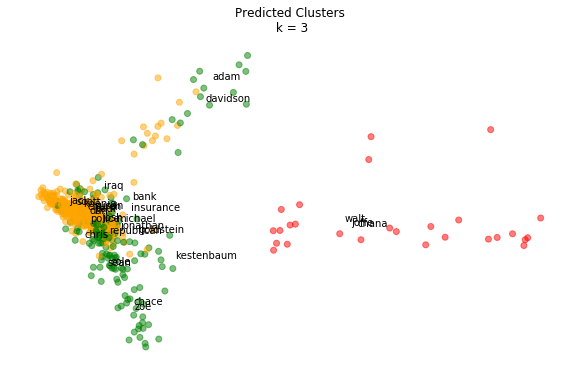

In [127]:
colors_p = [colordict[str(l)] for l in km3.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

Plot for k=4. Adding another group helps separate the comingling of the green and yellow groups in k=3.

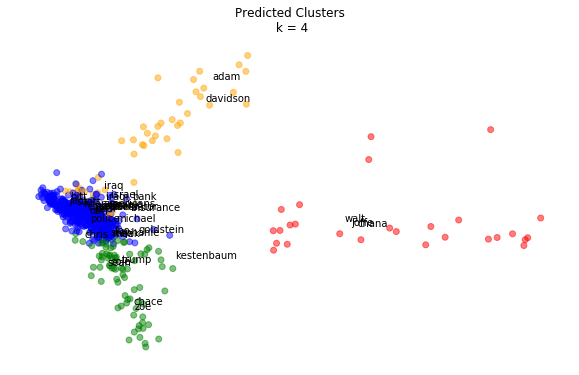

In [130]:
order_centroids = km4.cluster_centers_.argsort()[:, ::-1]
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

colors_p = [colordict[str(l)] for l in km4.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Plot for k=5. It's getting harder to tell how good the clustering is doing as there are emerging overlapping groups on the left side of the graph.

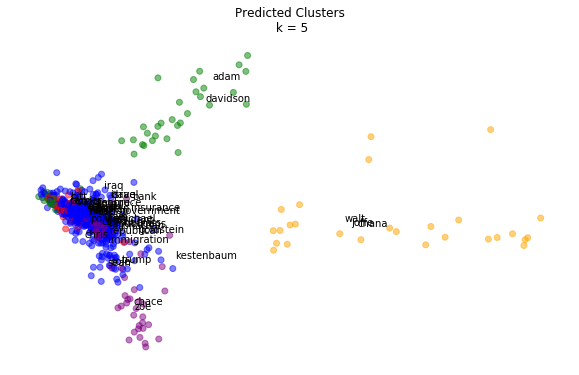

In [132]:
order_centroids = km5.cluster_centers_.argsort()[:, ::-1]
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

colors_p = [colordict[str(l)] for l in km5.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 5')
plt.show()

Plot for k=6. Similar to k=5, there is a lot of overlapping.

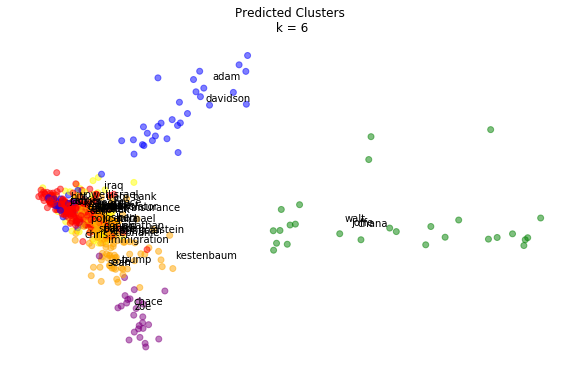

In [135]:
order_centroids = km6.cluster_centers_.argsort()[:, ::-1]
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

colors_p = [colordict[str(l)] for l in km6.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 6')
plt.show()

Plot for k=10. Again, lots of overlapping.

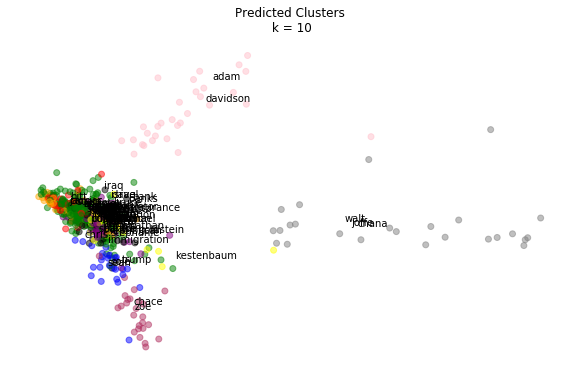

In [136]:
order_centroids = km10.cluster_centers_.argsort()[:, ::-1]
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

colors_p = [colordict[str(l)] for l in km10.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 10')
plt.show()

Silhouette Analysis: From k=3 to 10, I see a very low average silhouette score. This is likely related to the overlapping clusters observed in the plot above since a silhouette score close to 0 is an indicator of overlapping clusters.

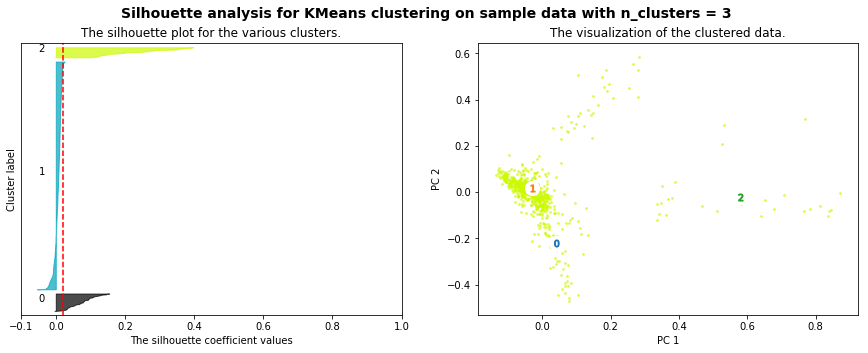

For n_clusters = 3, The average silhouette_score is : 0.020


In [140]:
X = talTFVects.toarray()
plotSilhouette(3, X)

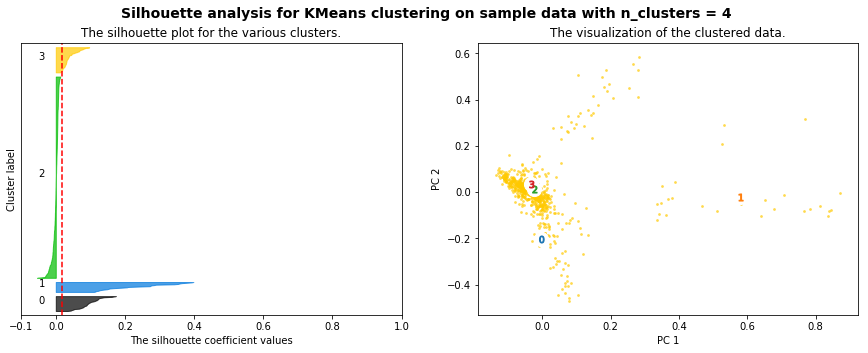

For n_clusters = 4, The average silhouette_score is : 0.018


In [141]:
X = talTFVects.toarray()
plotSilhouette(4, X)

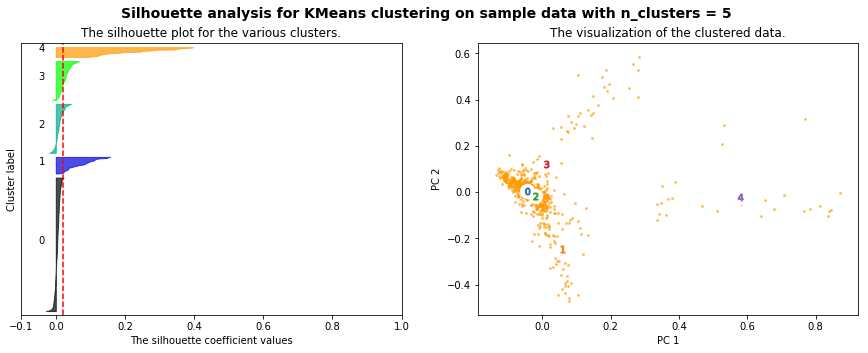

For n_clusters = 5, The average silhouette_score is : 0.022


In [142]:
X = talTFVects.toarray()
plotSilhouette(5, X)

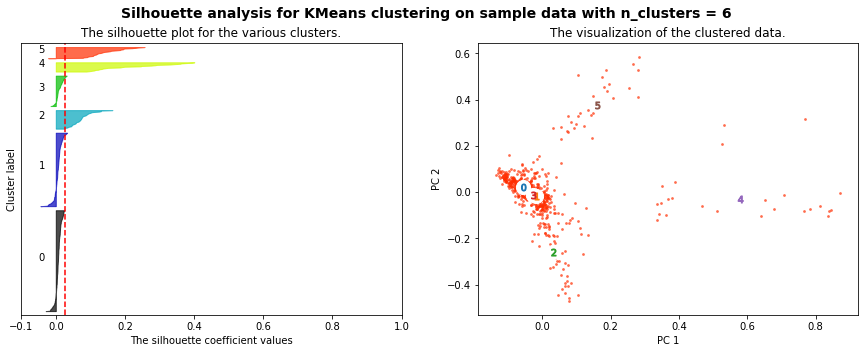

For n_clusters = 6, The average silhouette_score is : 0.026


In [143]:
X = talTFVects.toarray()
plotSilhouette(6, X)

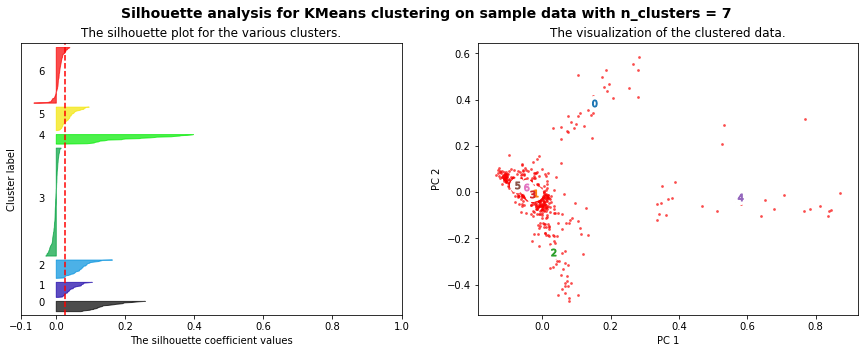

For n_clusters = 7, The average silhouette_score is : 0.028


In [198]:
X = talTFVects.toarray()
plotSilhouette(7, X)

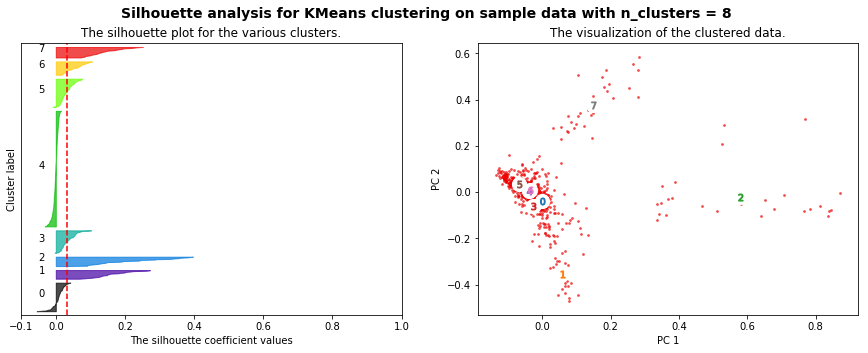

For n_clusters = 8, The average silhouette_score is : 0.031


In [199]:
X = talTFVects.toarray()
plotSilhouette(8, X)

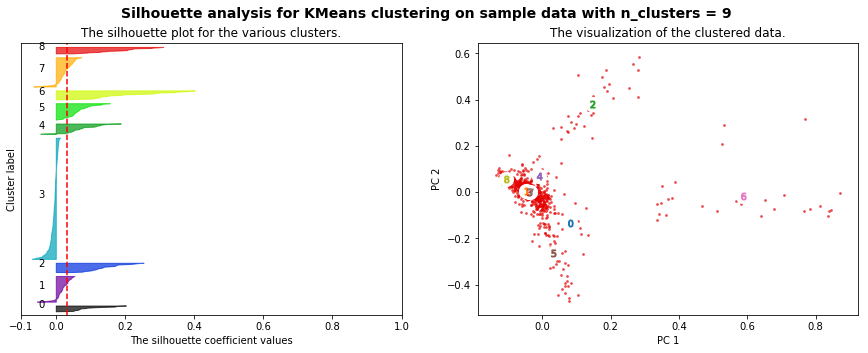

For n_clusters = 9, The average silhouette_score is : 0.032


In [200]:
X = talTFVects.toarray()
plotSilhouette(9, X)

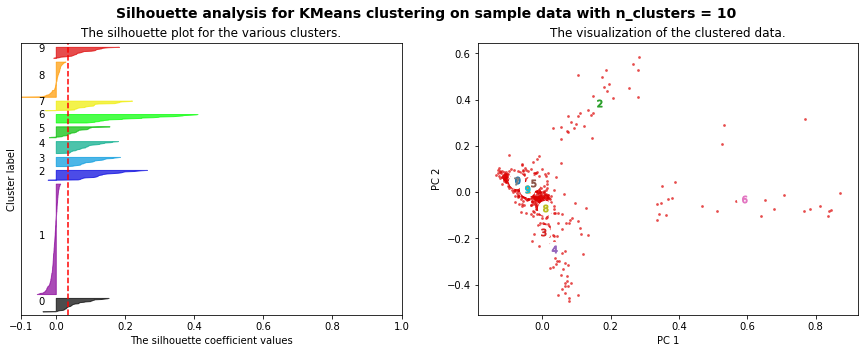

For n_clusters = 10, The average silhouette_score is : 0.035


In [201]:
X = talTFVects.toarray()
plotSilhouette(10, X)

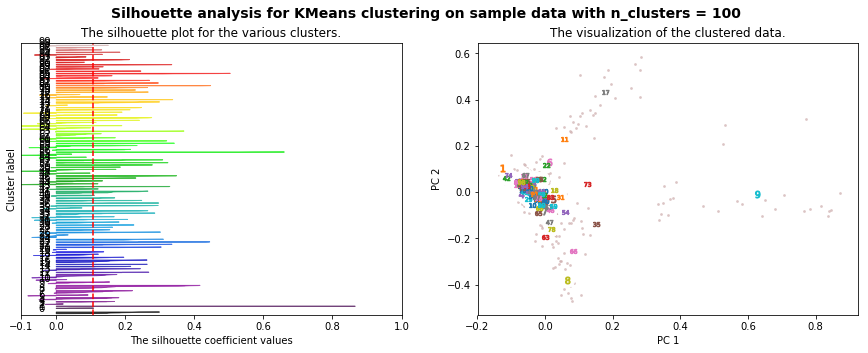

For n_clusters = 100, The average silhouette_score is : 0.107


In [203]:
X = talTFVects.toarray()
plotSilhouette(100, X)

Plotting the average silhouette score with increasing number of clusters up to 20, I see that it actually is mostly increasing but still very low. Kmeans is probably not the best way to cluster this corpus as it is right now. I am exploring the idea of removing names for my final project to see how that affects results.

In [218]:
X = talTFVects.toarray()
k_range = range(2,20)
vals = []
for k in k_range:
    clusterer = sklearn.cluster.KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    vals.append(silhouette_avg)

Text(0.5,1,'Avg Silhouette Score Over K Values (TAL)')

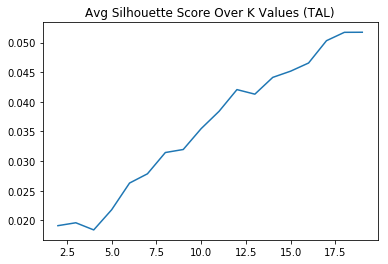

In [219]:
plt.plot(k_range,vals)
plt.title('Avg Silhouette Score Over K Values (TAL)')

Compare the average silhouette score plot to that of the News Group example which has a lot of variance in the average silhouette score across cluster sizes. The average number is also very low at around 0.01-0.02.

In [213]:
# for the newsgroup set
X = newsgroupsTFVects.toarray()
k_range = range(2,20)
vals = []
for k in k_range:
    clusterer = sklearn.cluster.KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    vals.append(silhouette_avg)

Text(0.5,1,'Avg Silhouette Score Over K Values (NewsGroups)')

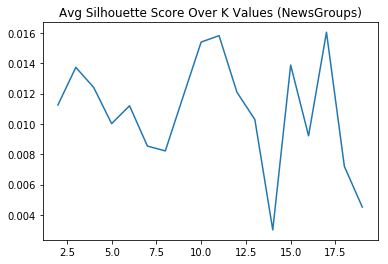

In [215]:
plt.plot(k_range,vals)
plt.title('Avg Silhouette Score Over K Values (NewsGroups)')

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [148]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [149]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [150]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/usr/local/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [151]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [152]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [153]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 76.        , 193.        ,   0.        ,   2.        ],
       [195.        , 200.        ,   0.        ,   3.        ],
       [198.        , 201.        ,   0.        ,   4.        ],
       [105.        , 202.        ,   0.37033177,   5.        ],
       [ 54.        , 169.        ,   0.40914841,   2.        ],
       [110.        , 144.        ,   0.44134524,   2.        ],
       [149.        , 162.        ,   0.45096656,   2.        ],
       [151.        , 204.        ,   0.4553535 ,   3.        ],
       [ 67.        , 206.        ,   0.4650683 ,   3.        ],
       [102.        , 146.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

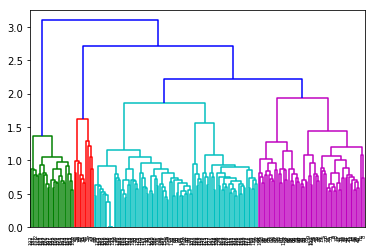

In [154]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

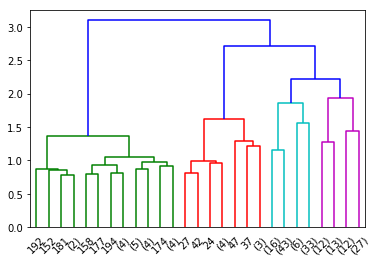

In [155]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [156]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4,
       3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [157]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [170]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF.head()

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [174]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/usr/local/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values
/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

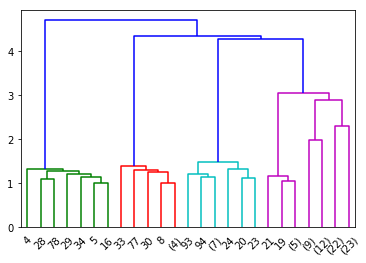

In [172]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [173]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

Method 1: create a word occurrence matrix measuring how similar the documents are to each other based on their number of shared words

In [73]:
talCoocMat = talTFVects * talTFVects.T
talCoocMat.setdiag(0)
tallinkage_matrix = scipy.cluster.hierarchy.ward(talCoocMat[:100, :100].toarray())

/usr/local/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values
/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Interestingly, there are two primary clusters when using hierarchical clustering. This seems in line with the silhouette scores close to zero I saw above using flat clustering. Hierarchical clustering might be grouping better due to the overlapping clusters.

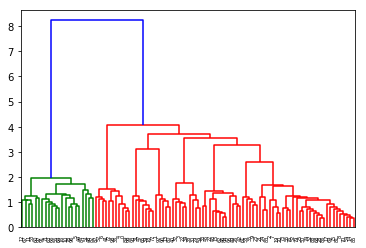

In [74]:
d=scipy.cluster.hierarchy.dendrogram(tallinkage_matrix, get_leaves=True)

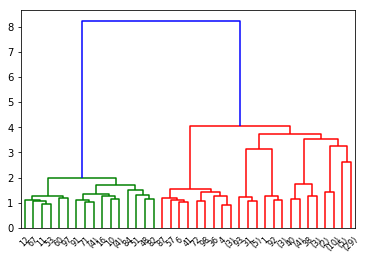

In [75]:
ax = scipy.cluster.hierarchy.dendrogram(tallinkage_matrix, p=5, truncate_mode='level')

Method 2: Using fcluster()

In [76]:
tal_linkage_matrix_full = scipy.cluster.hierarchy.ward(talCoocMat.toarray())
tal_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(tal_linkage_matrix_full, 4, 'maxclust')
tal_hierarchicalClusters_full

/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 3, 3, 4,
       3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 1, 4, 3, 4, 3, 4, 4, 4,
       4, 4, 1, 3, 1, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 4, 4, 1, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1,
       4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4, 2, 4, 4, 1, 4, 4, 4, 1, 4, 2, 4,
       4, 4, 2, 2, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Looking closer at the clusters:

In [77]:
c_df = tal_df
c_df['cluster'] = tal_hierarchicalClusters_full

By examining some of the episodes in the first cluster, it seems to be about race, sex, and challenging existing norms.

In [81]:
c_df[c_df.cluster==1].head()

,name,url,year,text,tokenized_text,normalized_tokens,reduced_tokens,group,cluster
1,Five Women,https://www.thisamericanlife.org/640/transcript,2018,"Prologue Ira Glass From WBEZ Chicago, it's Th...","[Prologue, Ira, Glass, From, WBEZ, Chicago, it...","[prologue, ira, glass, wbez, chicago, american...","[podcast, version, version, chana, joffe, walt...",5,1
37,To Be Real,https://www.thisamericanlife.org/620/transcript,2017,"Prologue Ira Glass From WBEZ Chicago, it's Th...","[Prologue, Ira, Glass, From, WBEZ, Chicago, it...","[prologue, ira, glass, wbez, chicago, american...","[chana, joffe, walt, chana, joffe, walt, studi...",5,1
80,It’ll Make Sense When You’re Older,https://www.thisamericanlife.org/583/transcript,2016,"Prologue Chana Joffe Walt From WBEZ Chicago,...","[Prologue, Chana, Joffe, Walt, From, WBEZ, Chi...","[prologue, chana, joffe, walt, wbez, chicago, ...","[chana, joffe, walt, chana, joffe, walt, begin...",5,1
90,The Problem We All Live With - Part Two,https://www.thisamericanlife.org/563/transcript,2015,Prologue Ira Glass Kiana Jackson is a kid who...,"[Prologue, Ira, Glass, Kiana, Jackson, is, a, ...","[prologue, ira, glass, kiana, jackson, kid, fr...","[notice, regular, social, private, exchange, c...",5,1
92,Birds & Bees,https://www.thisamericanlife.org/557/transcript,2015,"Prologue Chana Joffe Walt From WBEZ Chicago, ...","[Prologue, Chana, Joffe, Walt, From, WBEZ, Chi...","[prologue, chana, joffe, walt, wbez, chicago, ...","[chana, joffe, walt, chana, joffe, walt, press...",5,1


Cluster 2 is not as clear, one episode is about public shame while another is about special stories about Christmas.

In [82]:
c_df[c_df.cluster==2].head()

,name,url,year,text,tokenized_text,normalized_tokens,reduced_tokens,group,cluster
122,Tarred and Feathered,https://www.thisamericanlife.org/522/transcript,2014,"Prologue Ira Glass Hey, everybody, Ira Glass ...","[Prologue, Ira, Glass, Hey, everybody, Ira, Gl...","[prologue, ira, glass, hey, everybody, ira, gl...","[episode, episode, phrase, report, nelson, sti...",4,2
164,500!,https://www.thisamericanlife.org/500/transcript,2013,"Prologue Ira Glass From WBEZ Chicago, it's Th...","[Prologue, Ira, Glass, From, WBEZ, Chicago, it...","[prologue, ira, glass, wbez, chicago, american...","[episode, episode, episode, mark, terry, notic...",4,2
201,"Lights, Camera, Christmas!",https://www.thisamericanlife.org/482/transcript,2012,"Prologue Ira Glass OK, everybody Ready Read...","[Prologue, Ira, Glass, OK, everybody, Ready, R...","[prologue, ira, glass, okay, everybody, ready,...","[camera, christmas, parent, dog, animal, linda...",4,2
244,Contents Unknown,https://www.thisamericanlife.org/399/transcript,2010,Prologue Ira Glass Last resort letters aren't...,"[Prologue, Ira, Glass, Last, resort, letters, ...","[prologue, ira, glass, resort, letter, exactly...","[letter, secret, ron, phrase, letter, ron, ron...",4,2
256,Crybabies,https://www.thisamericanlife.org/415/transcript,2010,Prologue Ira Glass You may remember last fall...,"[Prologue, Ira, Glass, You, may, remember, las...","[prologue, ira, glass, remember, fall, preside...","[president, obama, decide, president, speech, ...",4,2


Cluster 3 documents seem to be about immigration, senate votes, and difficult decisions.

In [83]:
c_df[c_df.cluster==3].head()

,name,url,year,text,tokenized_text,normalized_tokens,reduced_tokens,group,cluster
10,The Impossible Dream,https://www.thisamericanlife.org/642/transcript,2018,"Prologue Ira Glass From WBEZ Chicago, it's Th...","[Prologue, Ira, Glass, From, WBEZ, Chicago, it...","[prologue, ira, glass, wbez, chicago, american...","[zoe, chace, follow, senator, election, senato...",5,3
11,Let Me Count the Ways,https://www.thisamericanlife.org/656/transcript,2018,"Prologue Ira Glass 7:00 AM, Tijuana, Mexico, ...","[Prologue, Ira, Glass, 7:00, AM, Tijuana, Mexi...","[prologue, ira, glass, 7:00, tijuana, mexico, ...","[mexico, border, cross, crowd, arm, karen, kar...",5,3
12,Where There Is a Will,https://www.thisamericanlife.org/662/transcript,2018,"Prologue: Prologue Ira Glass My friend Etgar,...","[Prologue, Prologue, Ira, Glass, My, friend, E...","[prologue, prologue, ira, glass, friend, etgar...","[army, israel, incredible, policy, army, israe...",5,3
16,The Unhappy Deciders,https://www.thisamericanlife.org/658/transcript,2018,Prologue: Prologue Ira Glass Remember when th...,"[Prologue, Prologue, Ira, Glass, Remember, whe...","[prologue, prologue, ira, glass, remember, new...","[miss, judge, video, online, exact, event, ori...",5,3
44,Fear and Loathing in Homer and Rockville,https://www.thisamericanlife.org/621/transcript,2017,"Prologue Ira Glass Years ago, the senior prod...","[Prologue, Ira, Glass, Years, ago, the, senior...","[prologue, ira, glass, year, ago, senior, prod...","[brian, reed, fish, brian, reed, political, so...",5,3


Cluster 4 seems to also have some political elements and about difficult situations between groups that do not get along.

In [80]:
c_df[c_df.cluster==4].head()

,name,url,year,text,tokenized_text,normalized_tokens,reduced_tokens,group,cluster
0,Before Things Went to Hell,https://www.thisamericanlife.org/665/transcript,2019,"Prologue: Prologue Ira Glass At one level, my...","[Prologue, Prologue, Ira, Glass, At, one, leve...","[prologue, prologue, ira, glass, level, grandm...","[student, teacher, student, social, quote, tra...",5,4
2,The Walls,https://www.thisamericanlife.org/641/transcript,2018,Prologue Ira Glass Mohamedsalem is 33 And hi...,"[Prologue, Ira, Glass, Mohamedsalem, is, 33, A...","[prologue, ira, glass, mohamedsalem, parent, w...","[parent, build, plus, plus, plus, plus, bear, ...",5,4
3,Chip in My Brain,https://www.thisamericanlife.org/635/transcript,2018,"Prologue Ira Glass From WBEZ Chicago, it's Th...","[Prologue, Ira, Glass, From, WBEZ, Chicago, it...","[prologue, ira, glass, wbez, chicago, american...","[parent, parent, reach, parent, brain, kestenb...",5,4
4,Before the Next One,https://www.thisamericanlife.org/659/transcript,2018,Prologue: Prologue Ira Glass It's a school tr...,"[Prologue, Prologue, Ira, Glass, It, 's, a, sc...","[prologue, prologue, ira, glass, school, try, ...","[student, safe, build, train, build, gun, box,...",5,4
5,My Effing First Amendment,https://www.thisamericanlife.org/645/transcript,2018,Prologue Ira Glass Zoe Chace Zoe Chace Yes Ir...,"[Prologue, Ira, Glass, Zoe, Chace, Zoe, Chace,...","[prologue, ira, glass, zoe, chace, zoe, chace,...","[zoe, chace, zoe, chace, zoe, chace, trip, zoe...",5,4


Breaking tree into four clusters has higher silhouette score using fcluster() has a higher silhouette score. Hierarchical clustering seems to perform better on my corpus.

In [292]:
sklearn.metrics.silhouette_score(talCoocMat, tal_hierarchicalClusters_full, metric='euclidean')

0.1701182290562432

Trying different distance metrics actually produces very different results. Using 'distance' has a lower silhouette score than 'euclidean', but still higher than flat clustering. Changing the threshold from 4 to 9 also changes the silhouette score.

In [293]:
# try using "distance" criterion
tal_linkage_matrix_full = scipy.cluster.hierarchy.ward(talCoocMat.toarray())
tal_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(tal_linkage_matrix_full, 4, 'distance')
np.unique(tal_hierarchicalClusters_full)

/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int32)

In [294]:
sklearn.metrics.silhouette_score(talCoocMat, tal_hierarchicalClusters_full, metric='euclidean')

0.09029319107790451

In [295]:
# try using "distance" criterion with different threshold
tal_linkage_matrix_full = scipy.cluster.hierarchy.ward(talCoocMat.toarray())
tal_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(tal_linkage_matrix_full, 9, 'distance')
np.unique(tal_hierarchicalClusters_full)

/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([1, 2, 3, 4, 5], dtype=int32)

In [296]:
sklearn.metrics.silhouette_score(talCoocMat, tal_hierarchicalClusters_full, metric='euclidean')

0.0662883594756964

In [297]:
# try using "inconsistent" criterion
tal_linkage_matrix_full = scipy.cluster.hierarchy.ward(talCoocMat.toarray())
tal_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(tal_linkage_matrix_full, 5, 'inconsistent')
np.unique(tal_hierarchicalClusters_full)

/usr/local/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([1], dtype=int32)

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [7]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [8]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [9]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [10]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [12]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [13]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [14]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [15]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(6, 0.97346896)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [16]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [18]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(7, 0.9714248)]",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.971425,0.00000,0.000000
101,02Feb2007Kennedy10.txt,"[(1, 0.9950345)]",0.0,0.995035,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
201,04May2006Kennedy8.txt,"[(2, 0.87647456), (5, 0.12140631)]",0.0,0.000000,0.876475,0.000000,0.000000,0.121406,0.00000,0.000000,0.00000,0.000000
301,06Jun2007Kennedy1.txt,"[(1, 0.9692946), (4, 0.028874382)]",0.0,0.969295,0.000000,0.000000,0.028874,0.000000,0.00000,0.000000,0.00000,0.000000
401,08Feb2005Kennedy0.txt,"[(3, 0.40976688), (9, 0.58096176)]",0.0,0.000000,0.000000,0.409767,0.000000,0.000000,0.00000,0.000000,0.00000,0.580962
501,09Nov2005Kennedy11.txt,"[(5, 0.95548636)]",0.0,0.000000,0.000000,0.000000,0.000000,0.955486,0.00000,0.000000,0.00000,0.000000
601,11Nov2005Kennedy6.txt,"[(1, 0.97236043)]",0.0,0.972360,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
701,13Jun2006Kennedy1.txt,"[(1, 0.017750077), (3, 0.46134597), (6, 0.1914...",0.0,0.017750,0.000000,0.461346,0.000000,0.000000,0.19147,0.022864,0.30493,0.000000
801,15Dec2005Kennedy5.txt,"[(9, 0.9982239)]",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.998224
901,16May2007Kennedy5.txt,"[(1, 0.076044716), (9, 0.88344175)]",0.0,0.076045,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.883442


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [20]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.973469,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.971425,0.000000,0.000000
2,0.0,0.664517,0.000000,0.0,0.000000,0.000000,0.329330,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.993981,0.000000,0.000000,0.000000
4,0.0,0.000000,0.283582,0.0,0.000000,0.000000,0.000000,0.000000,0.714315,0.000000
5,0.0,0.000000,0.000000,0.0,0.000000,0.037434,0.000000,0.000000,0.954735,0.000000
6,0.0,0.000000,0.587091,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.403637
7,0.0,0.012548,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.958775
8,0.0,0.574080,0.000000,0.0,0.421565,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.967528,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


First we can visualize as a stacked bar chart:

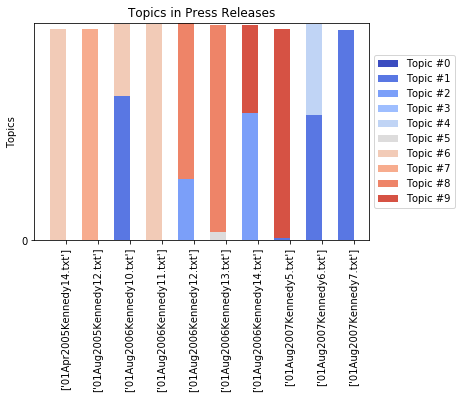

In [21]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

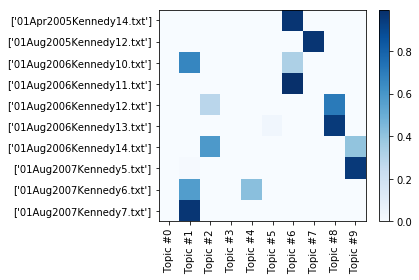

In [22]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [23]:
senlda.show_topic(1)

[('loan', 0.009216672),
 ('worker', 0.005144668),
 ('lender', 0.0050544585),
 ('troop', 0.0042990665),
 ('woman', 0.0041058),
 ('fund', 0.004018973),
 ('bankruptcy', 0.0039027096),
 ('immigration', 0.0038003912),
 ('hear', 0.0036948042),
 ('wage', 0.0035419993)]

And if we want to make a dataFrame:

In [24]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,worker,loan,worker,fund,loan,wage,fund,head,worker,fund
1,mental,worker,fund,medicare,worker,worker,loan,worker,wage,worker
2,immigration,lender,pension,company,fund,minimum,fda,troop,minimum,head
3,immigrant,troop,wage,loan,lender,fund,science,wage,employer,teacher
4,fund,woman,company,unite,pension,loan,worker,fund,unite,insurance
5,loan,fund,judge,asbestos,intelligence,company,lender,woman,city,loan
6,head,bankruptcy,rule,worker,unite,pension,unite,minimum,fund,train
7,association,immigration,employee,victim,victim,rate,teacher,unite,immigration,asbestos
8,unite,hear,woman,senior,disaster,rule,medicaid,question,immigrant,medicaid
9,coverage,wage,retirement,patient,company,attorney,coverage,ask,pension,immigration


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

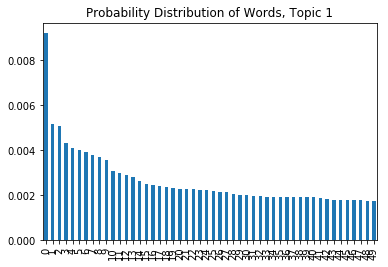

In [25]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [26]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

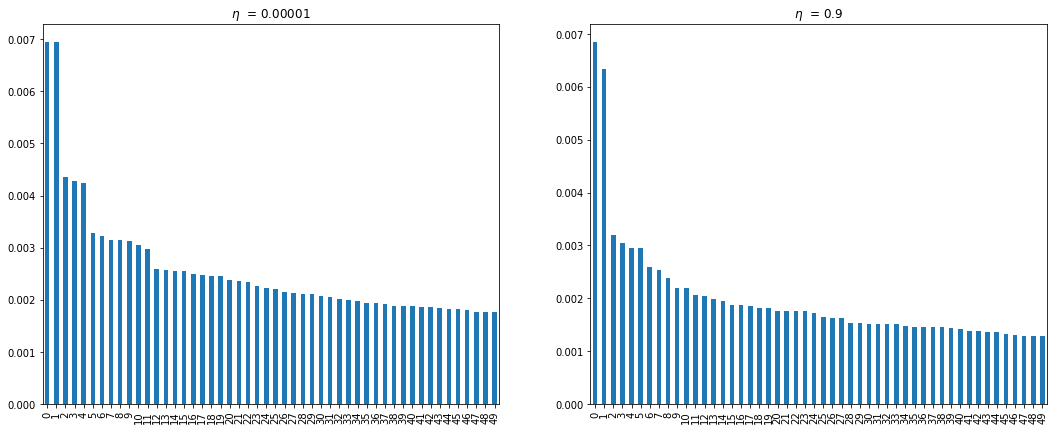

In [27]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

Prepare text and reduce the number of tokens

In [30]:
# tokenize
tal_df['tokenized_text'] = tal_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
tal_df['normalized_tokens'] = tal_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [39]:
# drop missing
tal_df['reduced_tokens'] = tal_df['normalized_tokens'].apply(lambda x: dropMissing(x, talTFVectorizer.vocabulary_.keys()))

Create the corpus for LDA

In [40]:
dictionary = gensim.corpora.Dictionary(tal_df['reduced_tokens'])

In [41]:
corpus = [dictionary.doc2bow(text) for text in tal_df['reduced_tokens']]

In [44]:
# serialize the corpus
gensim.corpora.MmCorpus.serialize('tal.mm', corpus)
talmm = gensim.corpora.MmCorpus('tal.mm')

Build LDA model and add it to the dataframe

In [46]:
#LDA model
tal_lda = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [50]:
tal1Bow = dictionary.doc2bow(tal_df['reduced_tokens'][0])
tal1lda = tal_lda[sen1Bow]
print("The topics of the text: {}".format(tal_df['name'][0]))
print("are: {}".format(tal1lda))

The topics of the text: Before Things Went to Hell
are: [(1, 0.053829823), (2, 0.89200914), (4, 0.024542043)]


In [51]:
# build df with topics for each text
tal_ldaDF = pandas.DataFrame({
        'name' : tal_df['name'],
        'topics' : [tal_lda[dictionary.doc2bow(l)] for l in tal_df['reduced_tokens']]
    })
tal_ldaDF.head()

,name,topics
0,Before Things Went to Hell,"[(0, 0.2658987), (1, 0.0132560525), (2, 0.0459..."
1,Five Women,"[(0, 0.9766545), (2, 0.021962665)]"
2,The Walls,"[(0, 0.22549894), (1, 0.20099393), (5, 0.08777..."
3,Chip in My Brain,"[(4, 0.012313438), (7, 0.9857378)]"
4,Before the Next One,"[(0, 0.020678973), (1, 0.11808993), (3, 0.3220..."


In [54]:
# make each topic its own column

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(tal_ldaDF) for i in range(tal_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(tal_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(tal_lda.num_topics):
    tal_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

tal_ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,Five Women,"[(0, 0.9766545), (2, 0.021962665)]",0.976655,0.000000,0.021963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101,Abdi and the Golden Ticket,"[(6, 0.9977804)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997780,0.000000,0.000000,0.000000
201,"Lights, Camera, Christmas!","[(0, 0.05003217), (4, 0.59524834), (8, 0.33483...",0.050032,0.000000,0.000000,0.000000,0.595248,0.000000,0.000000,0.000000,0.334836,0.017354
301,The Audacity of Government,"[(2, 0.14721723), (5, 0.084806725), (7, 0.3195...",0.000000,0.000000,0.147217,0.000000,0.000000,0.084807,0.000000,0.319542,0.000000,0.445414
401,Apology,"[(3, 0.60062104), (4, 0.3463813), (5, 0.039936...",0.000000,0.000000,0.000000,0.600621,0.346381,0.039936,0.000000,0.000000,0.000000,0.000000
501,Kids As Adults,"[(1, 0.26702768), (2, 0.01941094), (3, 0.53753...",0.000000,0.267028,0.019411,0.537537,0.058594,0.000000,0.000000,0.000000,0.021500,0.086639
601,Haunted,"[(0, 0.028003564), (3, 0.28256226), (4, 0.4154...",0.028004,0.000000,0.000000,0.282562,0.415405,0.233699,0.011952,0.000000,0.022114,0.000000


In [56]:
# subset to first 10 docs in corpus
tal_ldaDFV = tal_ldaDF[:10][['topic_%d' %x for x in range(10)]]
tal_ldaDFVisN = tal_ldaDF[:10][['name']]
tal_ldaDFVis = tal_ldaDFV.as_matrix(columns=None)
tal_ldaDFVisNames = tal_ldaDFVisN.as_matrix(columns=None)
tal_ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.265899,0.013256,0.045910,0.027095,0.052369,0.000000,0.000000,0.000000,0.000000,0.580971
1,0.976655,0.000000,0.021963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.225499,0.200994,0.000000,0.000000,0.000000,0.087777,0.011364,0.401772,0.063154,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.012313,0.000000,0.000000,0.985738,0.000000,0.000000
4,0.020679,0.118090,0.000000,0.322086,0.485477,0.011480,0.019065,0.000000,0.022542,0.000000
5,0.000000,0.856016,0.000000,0.000000,0.000000,0.000000,0.000000,0.102530,0.039628,0.000000
6,0.737484,0.000000,0.064622,0.000000,0.175688,0.000000,0.000000,0.000000,0.000000,0.018870
7,0.027447,0.000000,0.000000,0.174733,0.022929,0.299489,0.384286,0.000000,0.000000,0.087575
8,0.000000,0.240285,0.304924,0.284852,0.000000,0.168651,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.011911,0.000000,0.000000,0.027213,0.959677,0.000000,0.000000


Plot topics in stacked bar chart and heatmap. Although I ran the model with 10 topics, it seems like most episodes are dominated by 1 or 2. With this observation, I lower the number of topics to 5 for further observation.

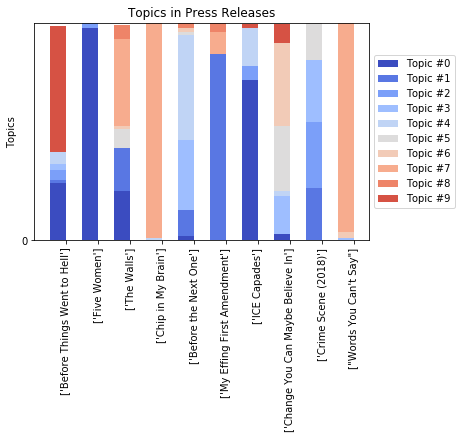

In [57]:
# stacked bar chart
N = 10
ind = np.arange(N)
K = tal_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += tal_ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in TAL Episodes')
plt.xticks(ind+width/2, tal_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

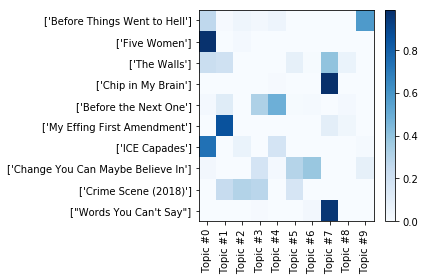

In [58]:
# heatmap
plt.pcolor(tal_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(tal_ldaDFVis.shape[0])+0.5, tal_ldaDFVisNames);
plt.xticks(np.arange(tal_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [62]:
# top words for each topic
topicsDict = {}
for topicNum in range(tal_lda.num_topics):
    topicWords = [w for w, p in tal_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,chana,chace,goldstein,koenig,sean,parent,police,kestenbaum,student,flake
1,walt,zoe,joffe,begin,parent,begin,begin,jonathan,adam,jeff
2,joffe,ben,jonathan,shoot,cole,paul,lose,decide,parent,zoe
3,build,reed,walt,lisa,begin,lose,parent,goldstein,decide,chace
4,paul,court,bank,mc,lie,die,shoot,koenig,begin,santa
5,sell,jonathan,chana,police,die,letter,government,begin,die,president
6,begin,begin,bob,die,doctor,matt,officer,parent,michael,die
7,government,drug,letter,gun,jonathan,koenig,ben,vote,build,lose
8,decide,brian,lose,decide,koenig,police,sell,gun,drink,decide
9,student,police,build,hospital,mark,dave,calhoun,student,brian,begin


<Figure size 432x288 with 0 Axes>

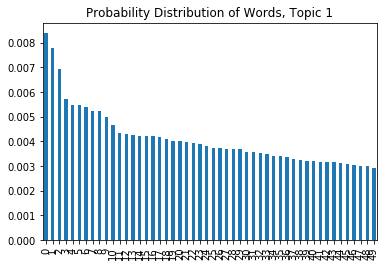

In [66]:
#visualization of the distribution of words over any single topic.
topic1_df = pandas.DataFrame(tal_lda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

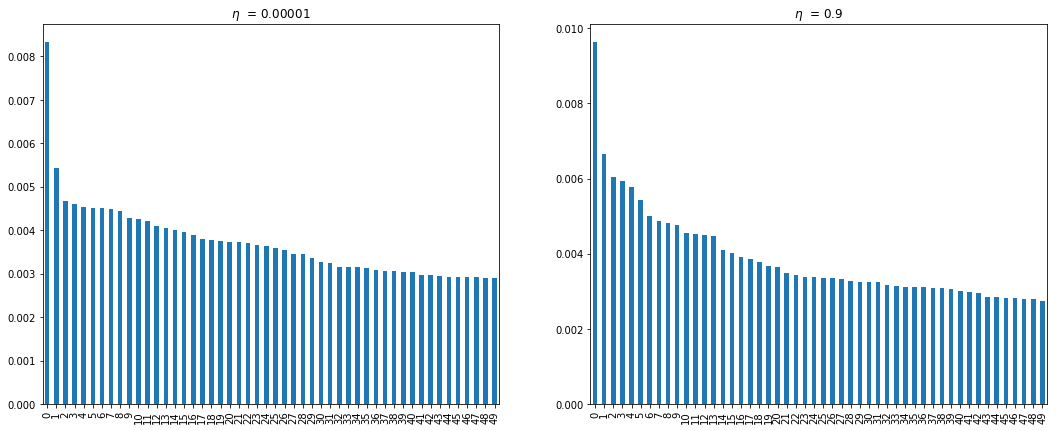

In [67]:
#different $\eta$ values can change the shape of the distribution.

tal_lda1 = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=10, eta = 0.00001)
tal_lda2 = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=10, eta = 0.9)

topic11_df = pandas.DataFrame(tal_lda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(tal_lda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

Many of the topics have the same top words, but there are definitely differences. As suggested in the provided example, I will try to make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

When varying the alpha and eta parameters, there is sometimes a shift in the distribution of topics in an episode. For example, Before the Next One has a distribution of topics under Alpha: asymmetric, eta= 0.2 whereas it is primarily one topic when using Alpha: asymmetric, eta= 0.5. Given the variation seen here, it seems like there are a lot of topics floating around in each episode.

Alpha: asymmetric, eta= 0.2

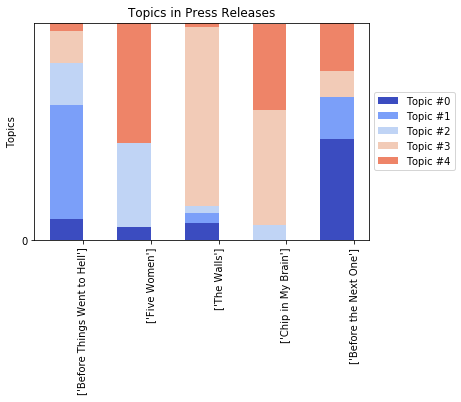

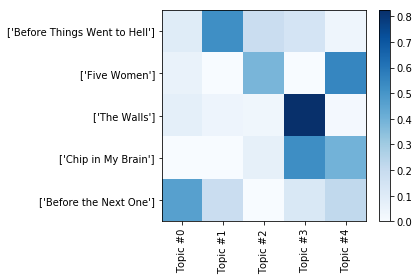

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,parent,begin,begin,parent,koenig
1,police,jack,lose,student,goldstein
2,begin,decide,jonathan,paul,die
3,decide,lie,michael,koenig,jonathan
4,die,lose,bank,police,chana
5,shoot,parent,walt,die,walt
6,build,meek,parent,court,student
7,lose,cole,joffe,begin,lose
8,chana,camp,drink,decide,build
9,walt,miki,zoe,drink,begin


In [92]:
a='asymmetric'
e=0.2
t=5
#LDA model
tal_lda = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=t, alpha='auto', eta='auto')

# topics df
tal_ldaDF = pandas.DataFrame({
        'name' : tal_df['name'],
        'topics' : [tal_lda[dictionary.doc2bow(l)] for l in tal_df['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(tal_ldaDF) for i in range(tal_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(tal_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(tal_lda.num_topics):
    tal_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
# subset to first 10 docs in corpus
tal_ldaDFV = tal_ldaDF[:t][['topic_%d' %x for x in range(t)]]
tal_ldaDFVisN = tal_ldaDF[:t][['name']]
tal_ldaDFVis = tal_ldaDFV.as_matrix(columns=None)
tal_ldaDFVisNames = tal_ldaDFVisN.as_matrix(columns=None)

# stacked bar chart
N = t
ind = np.arange(N)
K = tal_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += tal_ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, tal_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

# heatmap
plt.pcolor(tal_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(tal_ldaDFVis.shape[0])+0.5, tal_ldaDFVisNames);
plt.xticks(np.arange(tal_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

topicsDict = {}
for topicNum in range(tal_lda.num_topics):
    topicWords = [w for w, p in tal_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Alpha: asymmetric, eta = 0.5

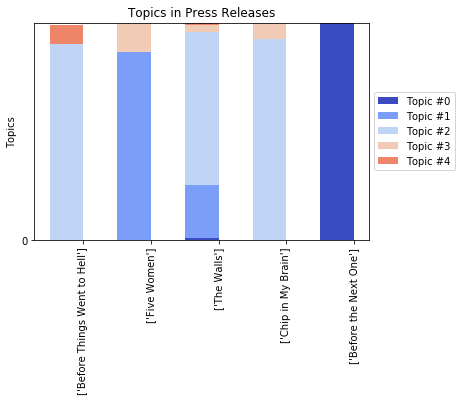

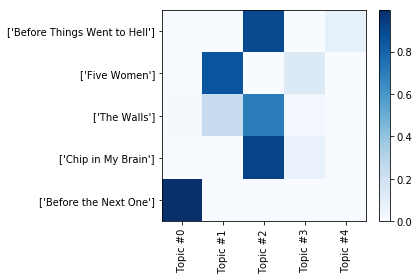

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,die,adam,begin,student,jonathan
1,parent,bank,kestenbaum,begin,begin
2,police,walt,parent,parent,decide
3,begin,lose,build,jonathan,lose
4,koenig,joffe,laugh,decide,zoe
5,shoot,frank,video,court,goldstein
6,sean,chana,police,walt,chace
7,student,build,lie,jack,paul
8,decide,paul,drink,ben,build
9,letter,davidson,lose,government,win


In [91]:
a='asymmetric'
e=0.5
#LDA model
tal_lda = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=5, alpha=a, eta=e)

# topics df
tal_ldaDF = pandas.DataFrame({
        'name' : tal_df['name'],
        'topics' : [tal_lda[dictionary.doc2bow(l)] for l in tal_df['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(tal_ldaDF) for i in range(tal_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(tal_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(tal_lda.num_topics):
    tal_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
# subset to first 10 docs in corpus
tal_ldaDFV = tal_ldaDF[:5][['topic_%d' %x for x in range(5)]]
tal_ldaDFVisN = tal_ldaDF[:5][['name']]
tal_ldaDFVis = tal_ldaDFV.as_matrix(columns=None)
tal_ldaDFVisNames = tal_ldaDFVisN.as_matrix(columns=None)

tal_ldaDF.head()# stacked bar chart
N = 5
ind = np.arange(N)
K = tal_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += tal_ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, tal_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

# heatmap
plt.pcolor(tal_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(tal_ldaDFVis.shape[0])+0.5, tal_ldaDFVisNames);
plt.xticks(np.arange(tal_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

topicsDict = {}
for topicNum in range(tal_lda.num_topics):
    topicWords = [w for w, p in tal_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Alpha: asymmetric, eta = 0.7

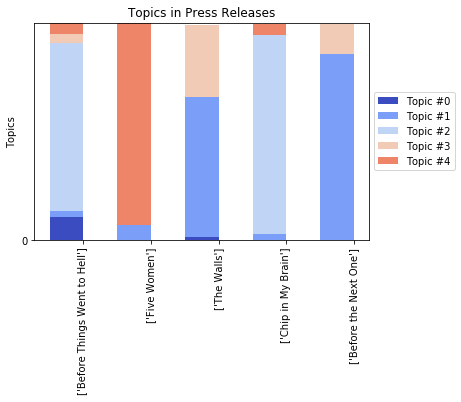

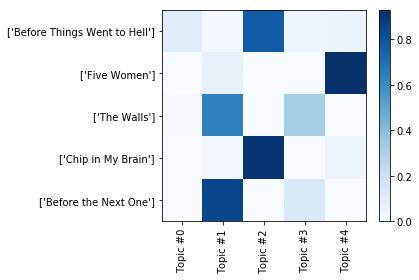

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,begin,parent,lose,government,joffe
1,mike,build,letter,lisa,decide
2,cole,koenig,begin,parent,walt
3,decide,walt,michael,paul,chana
4,die,begin,susan,sean,parent
5,parent,chana,decide,police,begin
6,shoot,police,jack,sell,die
7,koenig,lose,die,jack,church
8,drink,joffe,chicken,begin,court
9,sean,drink,jonathan,die,shoot


In [90]:
a='asymmetric'
e=0.7
t = 5
#LDA model
tal_lda = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=t, alpha=a, eta=e)

# topics df
tal_ldaDF = pandas.DataFrame({
        'name' : tal_df['name'],
        'topics' : [tal_lda[dictionary.doc2bow(l)] for l in tal_df['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(tal_ldaDF) for i in range(tal_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(tal_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(tal_lda.num_topics):
    tal_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
# subset to first 10 docs in corpus
tal_ldaDFV = tal_ldaDF[:t][['topic_%d' %x for x in range(t)]]
tal_ldaDFVisN = tal_ldaDF[:t][['name']]
tal_ldaDFVis = tal_ldaDFV.as_matrix(columns=None)
tal_ldaDFVisNames = tal_ldaDFVisN.as_matrix(columns=None)

tal_ldaDF.head()# stacked bar chart
N = t
ind = np.arange(N)
K = tal_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += tal_ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, tal_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

# heatmap
plt.pcolor(tal_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(tal_ldaDFVis.shape[0])+0.5, tal_ldaDFVisNames);
plt.xticks(np.arange(tal_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()


topicsDict = {}
for topicNum in range(tal_lda.num_topics):
    topicWords = [w for w, p in tal_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Alpha: 'auto', eta = 0.2

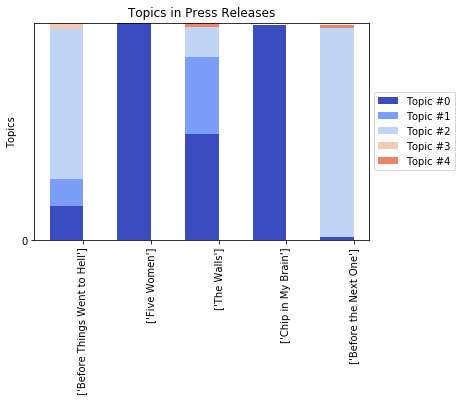

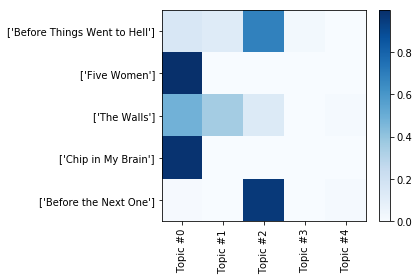

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,joffe,begin,cole,parent,koenig
1,chana,build,sean,goldstein,police
2,walt,ben,parent,die,parent
3,jack,decide,begin,begin,shoot
4,zoe,die,lisa,decide,lose
5,chace,lose,lie,jonathan,adam
6,begin,matt,president,koenig,die
7,decide,lie,scott,letter,president
8,lose,mike,lose,student,begin
9,parent,parent,laugh,church,court


In [89]:
a='auto'
e=0.2
t = 5
#LDA model
tal_lda = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=t, alpha=a, eta=e)

# topics df
tal_ldaDF = pandas.DataFrame({
        'name' : tal_df['name'],
        'topics' : [tal_lda[dictionary.doc2bow(l)] for l in tal_df['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(tal_ldaDF) for i in range(tal_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(tal_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(tal_lda.num_topics):
    tal_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
# subset to first 10 docs in corpus
tal_ldaDFV = tal_ldaDF[:t][['topic_%d' %x for x in range(t)]]
tal_ldaDFVisN = tal_ldaDF[:t][['name']]
tal_ldaDFVis = tal_ldaDFV.as_matrix(columns=None)
tal_ldaDFVisNames = tal_ldaDFVisN.as_matrix(columns=None)

tal_ldaDF.head()# stacked bar chart
N = t
ind = np.arange(N)
K = tal_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += tal_ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, tal_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

# heatmap
plt.pcolor(tal_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(tal_ldaDFVis.shape[0])+0.5, tal_ldaDFVisNames);
plt.xticks(np.arange(tal_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()


topicsDict = {}
for topicNum in range(tal_lda.num_topics):
    topicWords = [w for w, p in tal_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Alpha: auto, eta = 0.5

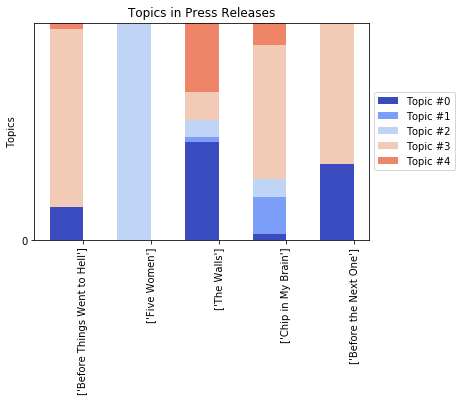

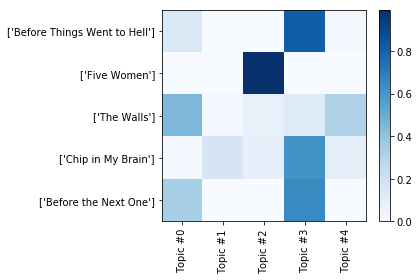

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,decide,parent,walt,student,police
1,build,begin,begin,chace,goldstein
2,lose,government,joffe,begin,koenig
3,michael,bank,chana,zoe,decide
4,parent,adam,parent,parent,die
5,police,lie,lose,joffe,build
6,jack,sell,die,chana,begin
7,president,paul,jonathan,ben,jonathan
8,paul,decide,drink,walt,lose
9,bob,koenig,koenig,vote,parent


In [93]:
a='auto'
e=0.5
t = 5
#LDA model
tal_lda = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=t, alpha=a, eta=e)

# topics df
tal_ldaDF = pandas.DataFrame({
        'name' : tal_df['name'],
        'topics' : [tal_lda[dictionary.doc2bow(l)] for l in tal_df['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(tal_ldaDF) for i in range(tal_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(tal_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(tal_lda.num_topics):
    tal_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
# subset to first 10 docs in corpus
tal_ldaDFV = tal_ldaDF[:t][['topic_%d' %x for x in range(t)]]
tal_ldaDFVisN = tal_ldaDF[:t][['name']]
tal_ldaDFVis = tal_ldaDFV.as_matrix(columns=None)
tal_ldaDFVisNames = tal_ldaDFVisN.as_matrix(columns=None)

tal_ldaDF.head()# stacked bar chart
N = t
ind = np.arange(N)
K = tal_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += tal_ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, tal_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

# heatmap
plt.pcolor(tal_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(tal_ldaDFVis.shape[0])+0.5, tal_ldaDFVisNames);
plt.xticks(np.arange(tal_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()


topicsDict = {}
for topicNum in range(tal_lda.num_topics):
    topicWords = [w for w, p in tal_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Alpha: auto, eta = 0.7

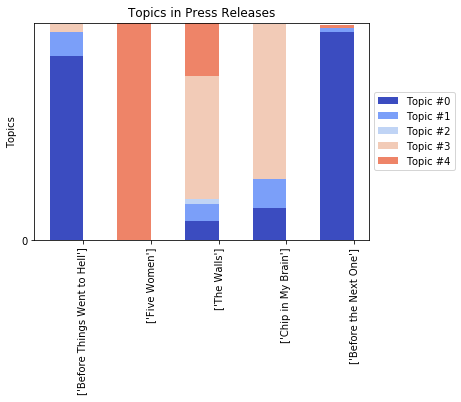

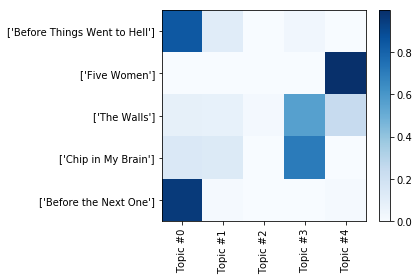

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,koenig,begin,begin,cole,chana
1,shoot,parent,jack,sean,walt
2,begin,decide,court,die,joffe
3,lose,chicken,koenig,lose,parent
4,letter,zoe,ben,goldstein,student
5,parent,chace,paul,parent,begin
6,student,die,adam,drink,government
7,matt,sell,president,chris,drug
8,die,lose,government,scott,police
9,decide,build,police,joe,michael


In [94]:
a='auto'
e=0.7
t = 5
#LDA model
tal_lda = gensim.models.ldamodel.LdaModel(corpus=talmm, id2word=dictionary, num_topics=t, alpha=a, eta=e)

# topics df
tal_ldaDF = pandas.DataFrame({
        'name' : tal_df['name'],
        'topics' : [tal_lda[dictionary.doc2bow(l)] for l in tal_df['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(tal_ldaDF) for i in range(tal_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(tal_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(tal_lda.num_topics):
    tal_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
# subset to first 10 docs in corpus
tal_ldaDFV = tal_ldaDF[:t][['topic_%d' %x for x in range(t)]]
tal_ldaDFVisN = tal_ldaDF[:t][['name']]
tal_ldaDFVis = tal_ldaDFV.as_matrix(columns=None)
tal_ldaDFVisNames = tal_ldaDFVisN.as_matrix(columns=None)

tal_ldaDF.head()# stacked bar chart
N = t
ind = np.arange(N)
K = tal_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, tal_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += tal_ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, tal_ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

# heatmap
plt.pcolor(tal_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(tal_ldaDFVis.shape[0])+0.5, tal_ldaDFVisNames);
plt.xticks(np.arange(tal_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()


topicsDict = {}
for topicNum in range(tal_lda.num_topics):
    topicWords = [w for w, p in tal_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Stretch: include topics in clustering. Here I add the topic distribution to the original TFVects and then train Kmeans on it with k=6. It looks like almost all topics show up in each cluster, which could indicate that the flat clustering is not doing a good job of separating out topics. This would be in line with the low silhouette scores I saw for various Kmeans models in Exercise 1.

In [109]:
t0 = np.array(tal_ldaDF['topic_0']).reshape(663,1)
t1 = np.array(tal_ldaDF['topic_1']).reshape(663,1)
t2 = np.array(tal_ldaDF['topic_2']).reshape(663,1)
t3 = np.array(tal_ldaDF['topic_3']).reshape(663,1)
t4 = np.array(tal_ldaDF['topic_4']).reshape(663,1)

In [120]:
add_topic = np.hstack((talTFVects.toarray(), t0))
add_topic = np.hstack((add_topic, t1))
add_topic = np.hstack((add_topic, t2))
add_topic = np.hstack((add_topic, t3))
add_topic = np.hstack((add_topic, t4))

In [130]:
numClusters = 6

km6 = train_km(numClusters, add_topic)

cluster_docs(numClusters, km6, tal_df)


Cluster: 0
10       The Impossible Dream
11      Let Me Count the Ways
12      Where There Is a Will
15    The Room of Requirement
16       The Unhappy Deciders
Name: name, dtype: object
Cluster: 1
7     Change You Can Maybe Believe In
14             In Dog We Trust (2018)
22           The Not-So-Great Unknown
25             Random Acts of History
29                      How I Read It
Name: name, dtype: object
Cluster: 2
9                         Words You Can't Say
17    It's My Party and I'll Try If I Want To
30               I Thought It Would Be Easier
58    So a Monkey and a Horse Walk Into a Bar
59                                 Seriously?
Name: name, dtype: object
Cluster: 3
2                   The Walls
3            Chip in My Brain
23     The Secret of My Death
26    Hoaxing Yourself (2018)
27          The Feather Heist
Name: name, dtype: object
Cluster: 4
1            Five Women
13              LaDonna
19    Damned If You Do…
20         The Runaways
37           To Be Real
N

In [137]:
terms = talTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km6.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        if ind < 1000:
            print(' %s' % terms[ind])
        elif ind == 1000:
            print('topic 0')
        elif ind == 1001:
            print('topic 1')
        elif ind == 1002:
            print('topic 2')
        elif ind == 1003:
            print('topic 3')
        else:
            print('topic 4')
    print('\n')

Top terms per cluster:
Cluster 0:
topic 1
topic 0
 zoe
 chace
topic 2
 chicken
topic 3
 susan
 dan
topic 4


Cluster 1:
topic 4
topic 0
topic 1
topic 3
topic 2
 jonathan
 mark
 josh
 jim
 goldstein


Cluster 2:
topic 2
 adam
 jack
topic 3
 hitt
topic 1
 davidson
 ben
topic 0
topic 4


Cluster 3:
topic 3
topic 0
topic 1
topic 2
 scott
 cole
 sean
 chris
 carrier
 iraq


Cluster 4:
topic 4
 chana
 joffe
 walt
topic 2
topic 1
 lisa
 michael
topic 3
topic 0


Cluster 5:
topic 0
topic 1
topic 3
 koenig
topic 2
topic 4
 carl
 jake
 robert
 police




## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [140]:
# I could not load this corpus

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [ ]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the first one, so I choose my index as 0. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][0]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [141]:
# I could not load this corpus so I looked at the tutorial instead.

In [3]:
corpora_address = "../data/COHA"

In [4]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [5]:
list(coha_texts.keys())[0:5]

['mag_1940_148025.txt',
 'mag_1940_148026.txt',
 'mag_1940_148027.txt',
 'mag_1940_148028.txt',
 'mag_1940_148029.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [6]:
coha_genres = {}
coha_years = {}

In [9]:
for article in coha_texts:

    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [10]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [11]:
coha_years.keys()

dict_keys(['1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1980', '1981', '1982', '1983

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [12]:
import collections

In [13]:
years = []
year_lens = []

In [14]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [15]:
years[0], years[-1]

('1810', '2009')

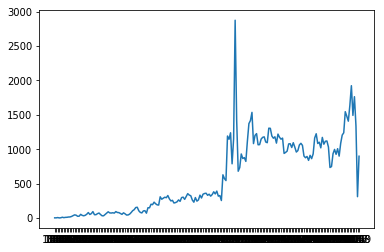

In [16]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: their are far less articles in the beginning, and then it grows. Maybe in our 4 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [20]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 10000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, 
                                 time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)

In [ ]:
ldaseq.print_topics(time=1)

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

First, I will examine the corpus to determine where the time slices will be for the dynamic topic model. I decide to have a window of about 5 years and there are therefore about 5 groups.

In [149]:
tal_df.groupby('year').count()['name']

year
1995     7
1996    40
1997    40
1998    31
1999    30
2000    26
2001    28
2002    25
2003    28
2004    24
2005    26
2006    17
2007    24
2008    25
2009    26
2010    25
2011    31
2012    28
2013    31
2014    29
2015    33
2016    30
2017    28
2018    30
2019     1
Name: name, dtype: int64

In [23]:
p1 = 7+40+40+31+30
p2 = 26+28+25+28+24
p3 = 26+17+24+25+26
p4 = 25+31+28+31+29
p5=33+30+28+30+1
time_slice = [p5,p4,p3,p2,p1]

Run the dynamic model:

In [72]:
tal_lda_dyn = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice,num_topics=3)

/usr/local/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/usr/local/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
/usr/local/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/usr/local/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/usr/local/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/usr/local/li

When comparing topics over time, it seems topic 1 doesn't actually change tha tmuch over time. It also is not extremely clear what it is about.

In [99]:
tal_lda_dyn.print_topics(time=0)[1]

[('begin', 0.007300066881336804),
 ('parent', 0.0070722967215821044),
 ('die', 0.006850221563792222),
 ('jonathan', 0.005841862490369849),
 ('laugh', 0.005460112593960095),
 ('wear', 0.005454821301647281),
 ('drink', 0.005407759859583332),
 ('song', 0.005406048037055349),
 ('decide', 0.005273571661137848),
 ('lose', 0.005112706249784491),
 ('joke', 0.005104154258558349),
 ('dog', 0.005059184241794371),
 ('letter', 0.005022408727265416),
 ('paul', 0.0049471526398004746),
 ('lie', 0.0048429971279319506),
 ('christmas', 0.004471549140757285),
 ('animal', 0.0044139664880237526),
 ('foot', 0.004347635442222277),
 ('hang', 0.004181206799076379),
 ('hello', 0.004149365671056424)]

In [100]:
tal_lda_dyn.print_topics(time=1)[1]

[('parent', 0.00827491389079719),
 ('begin', 0.007341783571431531),
 ('die', 0.006847070919011074),
 ('jonathan', 0.005790965826697334),
 ('drink', 0.005766953378612943),
 ('lose', 0.005551450356099686),
 ('laugh', 0.005402622718094534),
 ('song', 0.005355364071812399),
 ('decide', 0.005295347760392188),
 ('wear', 0.005109727289344131),
 ('letter', 0.005052856904382485),
 ('dog', 0.005035732885770703),
 ('paul', 0.005031337444852872),
 ('joke', 0.004727878536065124),
 ('lie', 0.004565216080376906),
 ('christmas', 0.004439909053574999),
 ('throw', 0.0043940176256577175),
 ('foot', 0.004361784106948697),
 ('hang', 0.0042633390806418306),
 ('park', 0.0040546020530369525)]

In [101]:
tal_lda_dyn.print_topics(time=2)[1]

[('parent', 0.009324880098148953),
 ('begin', 0.00737635484811043),
 ('die', 0.0068116775830678825),
 ('lose', 0.006023597780384752),
 ('drink', 0.005952713392282403),
 ('jonathan', 0.005645993327068157),
 ('song', 0.005467171030254832),
 ('decide', 0.0053106832045871685),
 ('laugh', 0.005296955135267866),
 ('paul', 0.0051685052321778155),
 ('letter', 0.005081532002829437),
 ('dog', 0.004951514158327762),
 ('wear', 0.004901563255077283),
 ('throw', 0.004542460185887655),
 ('lie', 0.004464221642730592),
 ('foot', 0.00437021391421318),
 ('hang', 0.004228289058642516),
 ('christmas', 0.004137734378931793),
 ('chicken', 0.0041126574181198266),
 ('park', 0.004089831179092945)]

In [102]:
tal_lda_dyn.print_topics(time=3)[1]

[('parent', 0.00881962543091454),
 ('begin', 0.007457812489313562),
 ('die', 0.006809179213936519),
 ('lose', 0.006041932850692439),
 ('song', 0.005773972292193626),
 ('drink', 0.005751751136105967),
 ('jonathan', 0.005507138218252259),
 ('paul', 0.005385875192742658),
 ('wear', 0.005375875567111745),
 ('decide', 0.005356000335270987),
 ('laugh', 0.005236652907904324),
 ('letter', 0.005158490495509887),
 ('dog', 0.004893757572255319),
 ('chicken', 0.0045855621656653795),
 ('lie', 0.00446895782077222),
 ('foot', 0.004421409042014618),
 ('throw', 0.004419820570486871),
 ('hello', 0.004337202635282614),
 ('susan', 0.0042515012641434645),
 ('hang', 0.004102935739716219)]

In [103]:
tal_lda_dyn.print_topics(time=4)[1]

[('parent', 0.008080012872148596),
 ('begin', 0.007523245907562877),
 ('die', 0.006814048992942838),
 ('song', 0.00620535175543577),
 ('paul', 0.005620200922144235),
 ('wear', 0.005544941847429985),
 ('jonathan', 0.005394971831770426),
 ('decide', 0.005389339832034046),
 ('chicken', 0.005369561344051649),
 ('drink', 0.0053270803977146),
 ('lose', 0.005300425089318184),
 ('letter', 0.00523218926394783),
 ('laugh', 0.005214875176480167),
 ('lie', 0.0051933094444220574),
 ('dog', 0.004866306559450672),
 ('sex', 0.004731221509272451),
 ('foot', 0.004481389310499576),
 ('susan', 0.004359098236808738),
 ('throw', 0.004318058827018055),
 ('dream', 0.004139813054611654)]

Looking at topic 0, it seems to be related to guns, police, and courts. However, I see that 'church' has steadily decreased in prominence over time (as time 0 is more recent). It was at 0.0055 in the last time period and starts at 0.00632. I wonder if this is an indication of decreased discussion of religion in relation to this topic and becoming more secular.

In [104]:
tal_lda_dyn.print_topic_times(topic=0)

[[('police', 0.016113170128462563),
  ('student', 0.00868487530858829),
  ('gun', 0.008205520238374299),
  ('shoot', 0.008129914368494693),
  ('officer', 0.008071651150246563),
  ('government', 0.00791578528345434),
  ('court', 0.007906366945675548),
  ('judge', 0.0068533224704797994),
  ('michael', 0.006743767219810043),
  ('brian', 0.006661820053583658),
  ('koenig', 0.006577867632102291),
  ('miki', 0.0064862145376561545),
  ('drug', 0.0064579052306070655),
  ('meek', 0.006379250493261956),
  ('jack', 0.006227064833279644),
  ('crime', 0.0060489579855495575),
  ('report', 0.005821436108101756),
  ('miller', 0.005792448299585473),
  ('build', 0.005724592087472032),
  ('church', 0.0055657083477212025)],
 [('police', 0.0146556559624981),
  ('court', 0.009335523902278133),
  ('student', 0.008593285106124535),
  ('government', 0.008080187008726685),
  ('shoot', 0.007742559289554707),
  ('officer', 0.007723862795393256),
  ('jack', 0.006724424276029522),
  ('koenig', 0.006704550600015405)

Topic 2 seems to be political. Interesting, the word 'bank' has decreased in prominence over time in this topic as it started at 0.011 and ends around 0.0066. Of course, Trump makes a sudden appearance in the most recent time period given his election to the presidency.

In [106]:
tal_lda_dyn.print_topic_times(topic=2)

[[('sean', 0.017630356276349794),
  ('chace', 0.016316023713653784),
  ('walt', 0.015904572819578935),
  ('chana', 0.015562092020336022),
  ('joffe', 0.015116579692948526),
  ('zoe', 0.013804008431203042),
  ('cole', 0.013308896809624273),
  ('kestenbaum', 0.011180534462071757),
  ('ben', 0.010765931773809762),
  ('vote', 0.009546055695352464),
  ('trump', 0.009408959668721474),
  ('president', 0.00793208823764734),
  ('adam', 0.007313737804090505),
  ('republican', 0.006994897000344111),
  ('foo', 0.006750263267323152),
  ('bank', 0.0066505247894135975),
  ('goldstein', 0.006620504489431249),
  ('mike', 0.006492162680664426),
  ('elna', 0.006306030279633198),
  ('steve', 0.006159099299258756)],
 [('walt', 0.015716389207799313),
  ('chana', 0.015359776479442217),
  ('joffe', 0.014810064630738052),
  ('koenig', 0.013919614287671364),
  ('cole', 0.01236912237139525),
  ('zoe', 0.011135644485996325),
  ('ben', 0.011021107145543217),
  ('adam', 0.010898143701586973),
  ('kestenbaum', 0.010

In [91]:
tal_lda_dyn.save("tal_lda_dyn")

In [92]:
loaded_model = ldaseqmodel.LdaSeqModel.load("tal_lda_dyn")